<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_5%5DClassifying_by_rock%2C_paper%2C_scissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_5]Classifying by rock, paper, scissor

## 1. import하기

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import glob
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


## 2.함수 만들기

### 1) 이미지 사이즈 변환
- 28X28 사이즈로 변경을 할 것이다.



In [2]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

### 2) load data

In [3]:
def load_data(img_path, number_of_data):
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

## 3. 이미지 사이즈 변환하기

In [4]:
# train_scissor
train_scissor_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/scissor"
resize_images(train_scissor_image_dir_path)

# train_rock
train_rock_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/rock"
resize_images(train_rock_image_dir_path)

# train_paper
train_paper_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/paper"
resize_images(train_paper_image_dir_path)

# test_scissor
test_scissor_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test/scissor"
resize_images(test_scissor_image_dir_path)

# test_rock
test_rock_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test/rock"
resize_images(test_rock_image_dir_path)

# test_paper
test_paper_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test/paper"
resize_images(test_paper_image_dir_path)

650  images to be resized.
650  images resized.
650  images to be resized.
650  images resized.
650  images to be resized.
650  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


## 4. train, test 데이터셋 불러오기 및 정규화
- 픽셀값은 0-255 사이의 값을 가진다. 인공지능 모델을 훈련시킬때 0-1사이로 정규화해주는 것이 더 높은 성능을 얻을 수 있다. 

### 1) train

In [5]:
train_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper"
(x_train, y_train)=load_data(train_image_dir_path,number_of_data=1950)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

학습데이터(x_train)의 이미지 개수는 1950 입니다.


In [6]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (1950, 28, 28, 3)
y_train shape: (1950,)


### 2) test

In [7]:
test_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test"
(x_test, y_test)=load_data(test_image_dir_path,number_of_data=300)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

학습데이터(x_train)의 이미지 개수는 300 입니다.


In [8]:
print("x_train shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_test.shape))

x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


## 5. 딥러닝 네트워크 설계

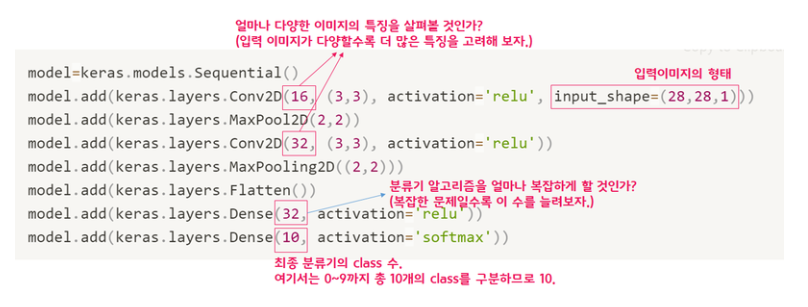

- Conv2D는 레이어의 첫번째 인자는 사용하는 이미지의 특징의 수이다. 정확도를 올리기 위해 손글씨보다 더 많은 특징의 수를 고려하 예정이다.
- input_shape는 손글씨와 다른 점이 마지막 숫자로 손글씨는 흑백으로 1을 설정하였지만 가위, 바위, 보는 모든 색을 나타내기 때문에 RGB 모두를 표현한 3을 기입하였다.
- Dense의 첫번째 인자는 분류기에 사용되는 뉴런의 숫자로 이 값이 클수록 보다 복잡한 분류기를 만들수 있다. 이 또한 정확도를 올리기 위해 손글찌보다 높은 숫자를 사용할 예정이다.
- 마지막 Dense 레이어의 뉴런 숫자는 분류해 내야 하는 클래수의 수로 손글씨와는 다르게 가위, 바위, 보로 클래스가 3개로 이루어져있어 3을 기입할 예정이다.
- https://keras.io/ko/getting-started/sequential-model-guide/ -> 해당 링크로 추가적인 공부를 할 수 있다.

In [9]:

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (N

## 6. 딥러닝 학습 및 검증

### 1) 모델 학습

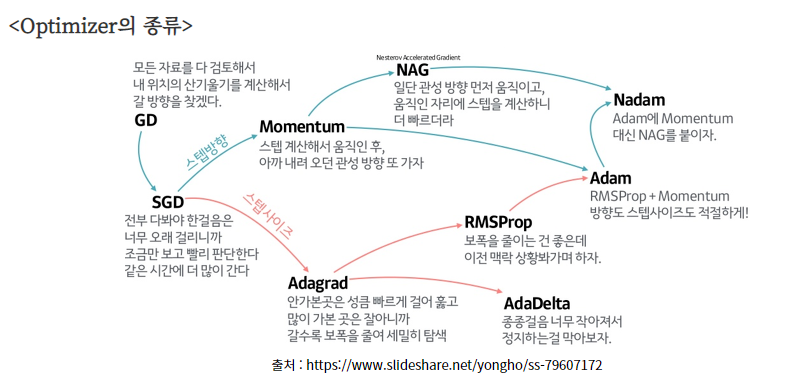

- 우리가 사용할 optimizer는 adam이다. 이는 RMSProp + Momentum방향도 스텝사이즈도 적절하게 한다는 뜻이다. 보다 구체적인 설명은 해당 링크로 가면 확인할 수 있다. -> https://ganghee-lee.tistory.com/24

- 우리가 사용할 loss는 "sparse_categorical_crossentropy"로 다중분류손실함수로 integer type 클래스를 one-hot encoding하지 않고 정수형태로 lable을 넣어주는 것으로 한 샘플에 여러 클래스가 있거나 label이 soft확률일 경우 사용한다.  다른 loss 함수를 알고 싶다면 해당 링크로 가면 된다. -> https://hororolol.tistory.com/375

In [10]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
             
history = model.fit(x_train, y_train,validation_split=0.25, epochs=9)

Epoch 1/9
46/46 [==============================] - 2s 11ms/step - loss: 3.2110 - accuracy: 0.5575 - val_loss: 1.7901 - val_accuracy: 0.0246
Epoch 2/9
46/46 [==============================] - 0s 6ms/step - loss: 0.4435 - accuracy: 0.8283 - val_loss: 1.2038 - val_accuracy: 0.3873
Epoch 3/9
46/46 [==============================] - 0s 6ms/step - loss: 0.2712 - accuracy: 0.8953 - val_loss: 2.5749 - val_accuracy: 0.0758
Epoch 4/9
46/46 [==============================] - 0s 6ms/step - loss: 0.1221 - accuracy: 0.9617 - val_loss: 2.1377 - val_accuracy: 0.2807
Epoch 5/9
46/46 [==============================] - 0s 6ms/step - loss: 0.0768 - accuracy: 0.9761 - val_loss: 2.6890 - val_accuracy: 0.3115
Epoch 6/9
46/46 [==============================] - 0s 6ms/step - loss: 0.0827 - accuracy: 0.9713 - val_loss: 2.3989 - val_accuracy: 0.3648
Epoch 7/9
46/46 [==============================] - 0s 6ms/step - loss: 0.0358 - accuracy: 0.9904 - val_loss: 3.2958 - val_accuracy: 0.3422
Epoch 8/9
46/46 [=========

- 해당 코드는 기존의 LMS 코드와 다른 점을 확인할 수 있는데 model fit한 것을 history에 넣었다는 것과 validation_split를 지정하였다는 것이다.
- history에 넣은 이유는 추후 그래프를 그리기 위함이다.
- validation은 이미 완료된 모델을 검증하기 위한 dataset이며 학습과 검증이 완료된 모델의 성능을 평가하기 위하여 추후 test 셋으로 평가를 할 것이다. 자세한 내용은 해당 링크를 통해 확인할 수 있다. 
  - -> https://ganghee-lee.tistory.com/38,                            
  - -> https://davincilabs.ai/blog/?q=YToxOntzOjEyOiJrZXl3b3JkX3R5cGUiO3M6MzoiYWxsIjt9&bmode=view&idx=10640969&t=board

### 2) 모델 검증

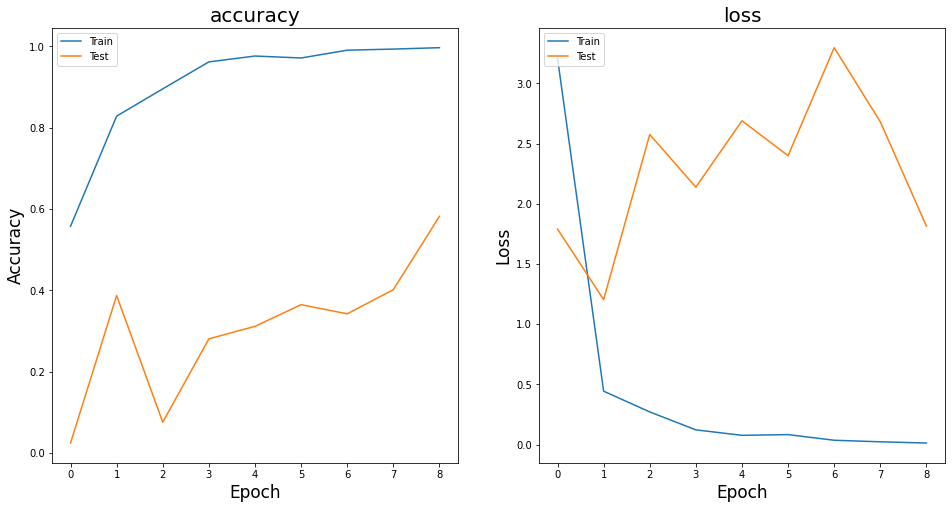

In [11]:
f, ax = plt.subplots(1,2,figsize=(16,8))


ax[0].plot(history.history['accuracy'] )
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('accuracy',fontsize=20)
ax[0].set_xlabel('Epoch',fontsize=17)
ax[0].set_ylabel('Accuracy',fontsize=17)
ax[0].legend(['Train', 'Test'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('loss',fontsize=20)
ax[1].set_xlabel('Epoch', fontsize=17)
ax[1].set_ylabel('Loss',fontsize=17)
ax[1].legend(['Train', 'Test'], loc='upper left')

plt.show()

- 모델 검증을 해보았을 때 그래프를 보니 그리 좋은 모델은 아닌 듯 하다. 학습 데이터의 갯수가 적어서 그런 것일 수도 있다. 이부분은 추후 확인해 자세히 확인해 볼 필요가 있다.

## 6. 평가지표 및 정확도, loss 확인

In [12]:
predicted_result = model.predict(x_test)  
predicted_labels = np.argmax(predicted_result, axis=1)

- 모델이 추론한 확률 값 및 배열에서 가장 높은 값을 가진 인덱스 값 반환

In [13]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))
print("\n",classification_report(y_test,predicted_labels))

10/10 - 0s - loss: 0.3454 - accuracy: 0.8733 - 44ms/epoch - 4ms/step
test_loss: 0.34540560841560364 
test_accuracy: 0.8733333349227905

               precision    recall  f1-score   support

           0       0.79      0.89      0.84       100
           1       0.92      0.99      0.95       100
           2       0.94      0.74      0.83       100

    accuracy                           0.87       300
   macro avg       0.88      0.87      0.87       300
weighted avg       0.88      0.87      0.87       300



- 이미지 분류이기 때문에 정확도 말고도 다른 분류를 측정하는 지표도 뽑아보았다. precision, recall, f1-score모두  비슷한 것을 확인해볼 수 있다. 

- model.evaluate 사용 : 케라스의 함수로 모델의 저확도를 평가할 수 있는 기능을 제공한다. 자세한 내용은 해당 링크로 -> https://thebook.io/080244/part04/unit16/07/

## 7. 어떤 데이터를 잘못 추론 했는지 확인

### 1) 가장 높은 결과와 실제 라벨이 어떠한지 확인해보기

model.predict() 결과 :  [9.9475467e-01 2.5432331e-05 5.2199140e-03]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


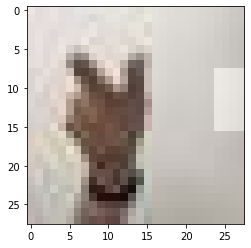

In [14]:
idx=0
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

- 가장 가능성이 높은 결과와 실제 데이터의 라벨은은 맞는 것으로 확인되었다.

### 2) 테스트 예측값과 테스트 실제 라벨이 다른 경우만 모으기

In [15]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

### 3) 랜덤 5개 확인

예측확률분포: [6.3271582e-01 5.7248764e-07 3.6728355e-01]
라벨: 2, 예측결과: 0


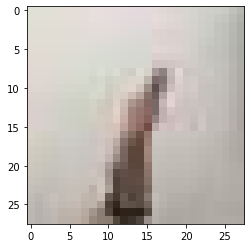

예측확률분포: [8.9249104e-01 2.9912227e-04 1.0720992e-01]
라벨: 2, 예측결과: 0


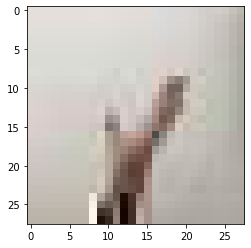

예측확률분포: [0.33030716 0.66525733 0.00443549]
라벨: 0, 예측결과: 1


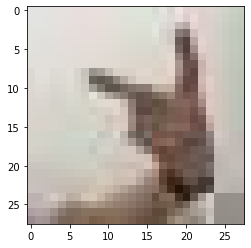

예측확률분포: [0.15568091 0.77859527 0.06572378]
라벨: 0, 예측결과: 1


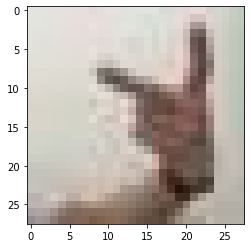

예측확률분포: [9.9532002e-01 4.5168115e-05 4.6347100e-03]
라벨: 2, 예측결과: 0


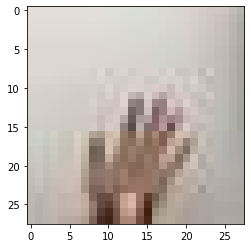

In [16]:
# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

### 4) 실제라벨 및 예측결과 총합 확인

In [17]:
# 전체 데이터셋중 무슨 값이 더 많이 틀렸는지 확인해본다.
count_0_p = 0
count_1_p = 0
count_2_p = 0
for n in wrong_predict_list:
  if str(predicted_labels[n]) == '0': # 가위
    count_0_p += 1
  if str(predicted_labels[n]) == '1': # 바위
    count_1_p += 1
  if str(predicted_labels[n]) == '2': # 보
    count_2_p += 1

count_0_y = 0
count_1_y = 0
count_2_y = 0
for n in wrong_predict_list:
  if str(y_test[n]) == '0': # 가위
    count_0_y += 1
  if str(y_test[n]) == '1': # 바위
    count_1_y += 1
  if str(y_test[n]) == '2': # 보
    count_2_y += 1

print('실제 라벨과 예측결과 총합 확인해보기')    
print('실제라벨 \n scissor : {}, rock : {}, paper : {}'.format(count_0_y, count_1_y, count_2_y))
print('예측결과 \n scissor : {}, rock : {}, paper : {}'.format(count_0_p, count_1_p, count_2_p))

실제 라벨과 예측결과 총합 확인해보기
실제라벨 
 scissor : 11, rock : 1, paper : 26
예측결과 
 scissor : 24, rock : 9, paper : 5


- 예측이 맞지 않는 5개의 예측 및 라벨 값을 확인해 보았다. 주로 scissor로 예측했는데 paper인 경우가 많았다. 

- 하지만 이는 random 값이니 정확하지는 않을 수 있지만 런타임을 다시 시작하고 여러분 시도해보았을때 대부분 scissor로 예측했지만 paper가 많이 나온 것을 확인해 볼 수 있어서 어느정도 신빙성은 있는 것 같다.

-  성능을 올리기 위해선 추후 보다 세밀하고 정확하게 확인해 볼 필요가 있을 것 같아서 확인을 해 보았다.
  - 그 결과 틀린예측중에 scissor로 예측한 경우가 많은 것을 확인해 볼 수 있다.
  - 그리고 다른 것으로 예측했는데 실제로 paper인 경우가 가장 많은 것을 확인해 볼 수 있다.
  - 즉. paper를 더 정확지 맞출 수 있도록, scissor에 대한 예측을 개선이 필요하다. 전처리 작업에서 개선해볼 수 있을 것 같다.

## 8. 회고

- 부르릭 조건을 맞추기 위해서 시도한 것
  - mldel.fit을 할 때 epochs를 10으로 하니 오히려 성능이 떨어진 것을 확인할 수 있었다. 해당 내용은 밑에 따로 이미지를 캡처해서 기재해 놓았다. 그래서 epochs를 9로 지정하였다.
  - 불러온 train, test를 255.0으로 나누어 정규화를 진행하였다.


- 추가로 시도해본 것
  - 검증데이터로 한 번 더 나누어 모델을 평가하기 전에 검증을 하였다. 
  - 이미지 분류 이기에 정확도 뿐만 아니라 classification_report를 통해 다양한 지표를 확인해 보았다.
  - 예측결과 및 실제라벨의 총 합계를 확인해보았다.


- 개선해야할 점
  - 검증을 통해서 그래프를 그려보았을때 그닥 좋은 성능을 보이기 있지 못한다. 정확도와 loss를 개선할 필요가 있다.
  - 예측결과 및 실제라벨의 총 합계를 확인해보았는데 이것을 어떻게 활용할 수 있을지 공부해볼 필요가 있다.
  - paper를 더 정확지 맞출 수 있도록, scissor에 대한 예측을 개선이 필요하다. 전처리 작업에서 개선해볼 수 있을 것 같다.

- 공부해야할 것
  - 검증에 대해 좀더 정확한 분석과 활용을 할 수 있도록 개념과 활용방향을 공부해 볼 필요가 있다.


- Tip
  - 코랩 표준 cpu와 ram으로 돌렷을때 밑에 게시한 사진처럼 0.66이라는 정확도가 나왔지만 고용량 ram과 GPU사용을 바꿨을때는 0.87까지 정확도가 오른 것을 확인해 볼 수 있다.

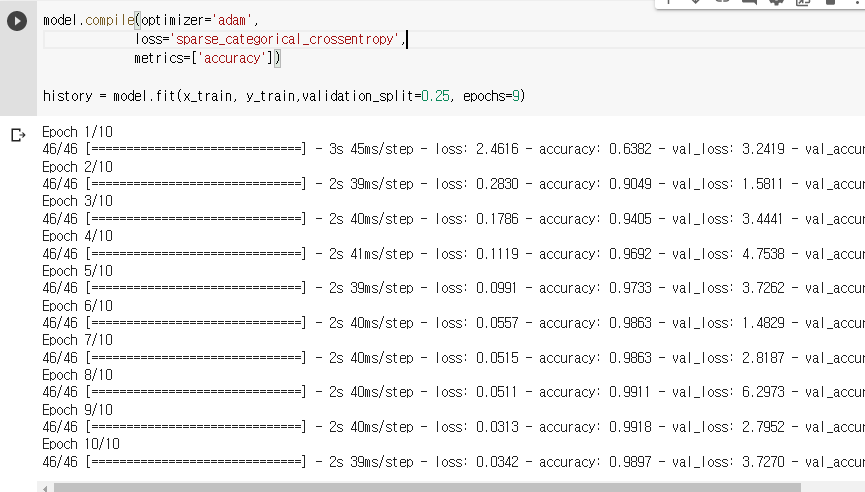

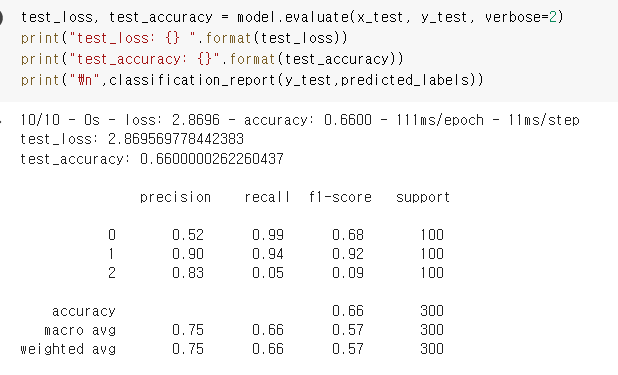